In [5]:
import torch
from pycocotools.coco import COCO

In [6]:
path = './data'
mode = '/train'
ann_path = path + mode + '/_annotations.coco.json'

# coco function
coco = COCO(ann_path)


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [7]:
coco.dataset

{'info': {'year': '2020',
  'version': '2',
  'description': 'Exported from roboflow.ai',
  'contributor': 'Northeastern University - China',
  'url': 'https://public.roboflow.ai/object-detection/hard-hat-workers',
  'date_created': '2020-04-30T03:26:22+00:00'},
 'licenses': [{'id': 1,
   'url': 'https://creativecommons.org/publicdomain/zero/1.0/',
   'name': 'Public Domain'}],
 'categories': [{'id': 0, 'name': 'Workers', 'supercategory': 'none'},
  {'id': 1, 'name': 'head', 'supercategory': 'Workers'},
  {'id': 2, 'name': 'helmet', 'supercategory': 'Workers'},
  {'id': 3, 'name': 'person', 'supercategory': 'Workers'}],
 'images': [{'id': 0,
   'license': 1,
   'file_name': '002310_jpg.rf.0008cd4590d2edb0e1447329236d9c11.jpg',
   'height': 319,
   'width': 489,
   'date_captured': '2020-04-30T03:26:22+00:00'},
  {'id': 1,
   'license': 1,
   'file_name': '003626_jpg.rf.0024e8fc3c8c3f411962ca8dab7b8e92.jpg',
   'height': 384,
   'width': 500,
   'date_captured': '2020-04-30T03:26:22+00:

In [8]:
len(coco.imgToAnns.keys())

5269

In [9]:
coco.dataset['categories']

[{'id': 0, 'name': 'Workers', 'supercategory': 'none'},
 {'id': 1, 'name': 'head', 'supercategory': 'Workers'},
 {'id': 2, 'name': 'helmet', 'supercategory': 'Workers'},
 {'id': 3, 'name': 'person', 'supercategory': 'Workers'}]

In [10]:
from torch.utils.data import Dataset

class Custom_Dataset(Dataset):
    def __init__(self, path, mode, transforms=None):
        # file path
        self.path = path + '/data' + mode
        
        self.ann_path = self.path  + '/_annotations.coco.json'

        # coco function
        self.coco = COCO(self.ann_path)

        # image num
        self.image_ids = list(self.coco.imgToAnns.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_name = self.coco.loadImgs(image_id)[0]['file_name']
        file_name = f'{self.path}/{file_name}'
        image = Image.open(file_name).convert('RGB')

        annot_ids = self.coco.getAnnIds(imgIds=image_id)
        annots = [x for x in self.coco.loadAnns(annot_ids) if x['image_id'] == image_id]
        
        boxes = np.array([annot['bbox'] for annot in annots], dtype=np.float32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = np.array([annot['category_id'] for annot in annots], dtype=np.int32)

        area = np.array([annot['area'] for annot in annots], dtype=np.float32)
        iscrowd = np.array([annot['iscrowd'] for annot in annots], dtype=np.uint8)

        target = {
            'boxes': boxes,
            'labels': labels,
            'area': area,
            'iscrowd': iscrowd}
        
        # if self.transforms is not None:
        #     image, target = self.transforms(image, target)
            
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
        target['area'] = torch.as_tensor(target['area'], dtype=torch.float32)
        target['iscrowd'] = torch.as_tensor(target['iscrowd'], dtype=torch.uint8)            

        return image, target

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
(319, 489, 3)
5269


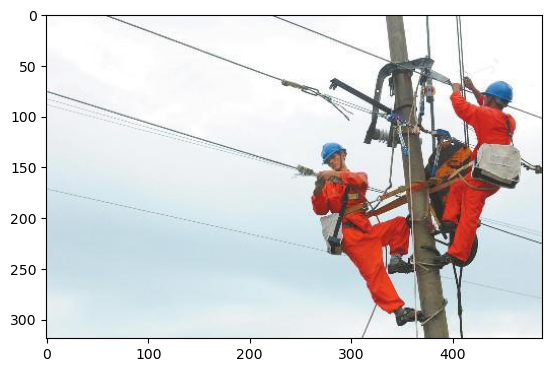

In [11]:
import torch.utils
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import csv
import json
import copy

import torch
from torch.utils.data import Dataset

path = '.'
mode = '/train'
dataset = Custom_Dataset(path, mode, None)

image = dataset[0][0]
print(np.array(image).shape)
plt.imshow(image)

print(len(dataset))

In [12]:
import os
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO

from torch.utils.data import Dataset

class Custom_Dataset(Dataset):
    def __init__(self, path, mode, transforms=None):

        # transforms 
        self.transforms = transforms
        # file path
        self.path = os.path.join(path, 'warehouse_data', mode)
        self.ann_path = os.path.join(self.path, f'warehouse_coco_{mode}.json')
        # coco function
        self.coco = COCO(self.ann_path)
        # image num
        self.image_ids = list(self.coco.imgToAnns.keys())
        print(f'{mode}_dataset length : {len(self.image_ids)}')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_name = self.coco.loadImgs(image_id)[0]['file_name']
        file_name = f'{self.path}/{file_name}'
        image = Image.open(file_name).convert('RGB')

        annot_ids = self.coco.getAnnIds(imgIds=image_id)
        annots = [x for x in self.coco.loadAnns(annot_ids) if x['image_id'] == image_id]
        
        boxes = np.array([annot['bbox'] for annot in annots], dtype=np.float32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = np.array([annot['category_id'] for annot in annots], dtype=np.int32)

        area = np.array([annot['area'] for annot in annots], dtype=np.float32)
        iscrowd = np.array([annot['iscrowd'] for annot in annots], dtype=np.uint8)

        target = {
            'boxes': boxes,
            'labels': labels,
            'area': area,
            'iscrowd': iscrowd}
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
            
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
        target['area'] = torch.as_tensor(target['area'], dtype=torch.float32)
        target['iscrowd'] = torch.as_tensor(target['iscrowd'], dtype=torch.uint8)            

        return image, target

In [13]:
path = os.path.join(path, 'warehouse_data', mode)
ann_path = os.path.join(path, f'warehouse_coco_{mode}.json')
# coco function
coco = COCO(ann_path)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/train/warehouse_coco_/train.json'

In [20]:
path = './warehouse_data'
mode = 'train'
ann_path = os.path.join(path, mode,f'warehouse_coco_{mode}.json')

In [21]:
coco = COCO(ann_path)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [22]:
coco.dataset.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [23]:
temp = []
for idx, ann in enumerate(coco.dataset['annotations']):
    if ann['category_id'] == 'UC-06':
        temp.append(idx)

In [24]:
len(temp)

0

In [25]:
dataset = coco.dataset

In [26]:
for idx, ann in enumerate(dataset['annotations']):
    if ann['category_id'] == "UC-06":
        del dataset['annotations'][idx]

In [27]:
temp = []
for idx, ann in enumerate(coco.dataset['annotations']):
    if ann['category_id'] == 'UC-06':
        print(ann)
        temp.append(idx)

In [28]:
len(temp)

0

In [29]:
len(dataset['annotations'])

31130

In [30]:
cls_li = []
for idx, ann in enumerate(dataset['annotations']):
    cls_li.append(ann['category_id'])

In [31]:
set(cls_li)

{'SO-02',
 'SO-03',
 'SO-06',
 'SO-07',
 'SO-21',
 'SO-22',
 'WO-01',
 'WO-02',
 'WO-03',
 'WO-04'}